In [1]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/alexs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alexs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alexs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize
    words = word_tokenize(text.lower())
    # Lemmatize and filter words, removing stopwords
    return ([lemmatizer.lemmatize(word) for word in words 
                     if word.isalnum()])


In [4]:
# Assuming the txt_sentoken files are in a directory named 'txt_sentoken' with 'pos' and 'neg' subdirectories
sentoken_dir = 'txt_sentoken'
pos_documents = []
neg_documents = []
file_names = []
labels = []

for sentiment in ['pos', 'neg']:
    sentiment_dir = os.path.join(sentoken_dir, sentiment)
    for filename in os.listdir(sentiment_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(sentiment_dir, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                preprocessed_text = preprocess(text)
                if sentiment == 'pos':
                    pos_documents.append(preprocessed_text)
                else:
                    neg_documents.append(preprocessed_text)
                file_names.append(f"{sentiment}_{filename}")
                labels.append(sentiment)

# Calculate word frequencies for positive and negative reviews
pos_words = Counter([word for doc in pos_documents for word in doc])
neg_words = Counter([word for doc in neg_documents for word in doc])

# Define thresholds for high frequency
pos_threshold = len(pos_documents) * 0.8
neg_threshold = len(neg_documents) * 0.8
# Find common high-frequency words
common_high_freq_words = set(word for word in pos_words.keys() & neg_words.keys()
                             if pos_words[word] > pos_threshold and neg_words[word] > neg_threshold)

print(f"Number of common high-frequency words: {len(common_high_freq_words)}")

# Remove common high-frequency words from documents
pos_documents = [[word for word in doc if word not in common_high_freq_words] for doc in pos_documents]
neg_documents = [[word for word in doc if word not in common_high_freq_words] for doc in neg_documents]

# Combine documents
documents = [' '.join(doc) for doc in pos_documents + neg_documents]

print(f"Number of documents processed: {len(documents)}")

# Print some statistics
print(f"Average document length after removal: {sum(len(doc.split()) for doc in documents) / len(documents):.2f} words")
print(f"Number of unique words in corpus: {len(set(word for doc in documents for word in doc.split()))}")


Number of common high-frequency words: 83
Number of documents processed: 2000
Average document length after removal: 333.28 words
Number of unique words in corpus: 34149


In [5]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.85)

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Calculate cosine similarity
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Set diagonal to 0 to exclude self-similarity
np.fill_diagonal(cosine_similarities, 0)

# Get the top 5 most similar pairs
num_top_pairs = 5
top_pairs = []

for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        similarity = cosine_similarities[i, j]
        top_pairs.append((file_names[i], file_names[j], similarity))

top_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 5 most similar document pairs:")
for i, (doc1, doc2, similarity) in enumerate(top_pairs[:num_top_pairs], 1):
    print(f"{i}. {doc1} and {doc2}: {similarity:.4f}")


Top 5 most similar document pairs:
1. neg_cv302_26481.txt and neg_cv274_26379.txt: 1.0000
2. neg_cv656_25395.txt and neg_cv412_25254.txt: 1.0000
3. pos_cv759_13522.txt and pos_cv174_9659.txt: 1.0000
4. pos_cv274_25253.txt and pos_cv115_25396.txt: 0.9996
5. pos_cv383_13116.txt and pos_cv986_13527.txt: 0.9995


Mean similarity for positive reviews: 0.0486
Mean similarity for negative reviews: 0.0499
Mean similarity between positive and negative reviews: 0.0242


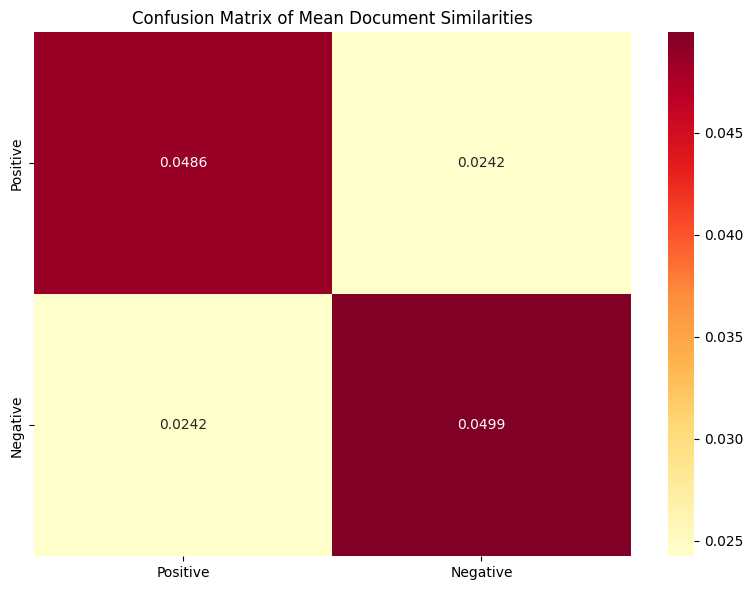

In [6]:
# ... existing code ...

# Calculate cosine similarities for each category
tr_pos_docs = [' '.join(doc) for doc in pos_documents]
tr_neg_docs = [' '.join(doc) for doc in neg_documents]

tfidf_matrix_pos = vectorizer.fit_transform(tr_pos_docs)
tfidf_matrix_neg = vectorizer.fit_transform(tr_neg_docs)

pos_similarities = cosine_similarity(tfidf_matrix_pos, tfidf_matrix_pos)
neg_similarities = cosine_similarity(tfidf_matrix_neg, tfidf_matrix_neg)
pos_neg_similarities = cosine_similarity(tfidf_matrix_pos, tfidf_matrix_neg)

np.fill_diagonal(pos_similarities, 0)
np.fill_diagonal(neg_similarities, 0)
np.fill_diagonal(pos_neg_similarities, 0)

# Remove self-similarities (diagonal)
np.fill_diagonal(pos_similarities, np.nan)
np.fill_diagonal(neg_similarities, np.nan)

# Calculate mean similarities
mean_pos_similarity = np.nanmean(pos_similarities)
mean_neg_similarity = np.nanmean(neg_similarities)
mean_pos_neg_similarity = np.nanmean(pos_neg_similarities)

print(f"Mean similarity for positive reviews: {mean_pos_similarity:.4f}")
print(f"Mean similarity for negative reviews: {mean_neg_similarity:.4f}")
print(f"Mean similarity between positive and negative reviews: {mean_pos_neg_similarity:.4f}")

# Create a 2x2 confusion matrix for the heatmap
confusion_matrix = np.array([[mean_pos_similarity, mean_pos_neg_similarity],
                             [mean_pos_neg_similarity, mean_neg_similarity]])

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='YlOrRd', 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'],
            fmt='.4f')
plt.title('Confusion Matrix of Mean Document Similarities')
plt.tight_layout()
plt.show()

